In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.optimize import root, least_squares
# !pip install mesa_reader 
from mesa_reader import MesaData

In [39]:
"""
Choose values for the star’s mass M∗, hydrogen mass fraction X, helium mass
fraction Y , and metal mass fraction Z = 1 − X − Y .
"""
# Constants in CGS
M_sun = 1.989e+33
G = 6.67430e-8 
a = 7.5646e-15 
sb = 5.6704e-5
c = 2.9979e+10 
N_a   = 6.0221e23
k_b   = 1.3807e-16

M = 1.2 * M_sun
X = 0.7
Y = 0.28
Z = 1 -X -Y

mu = 4 / (3 + 5*X)

In [40]:
"""
Write your own function to calculate density given pressure P , temperature, and
composition (i.e., the equation of state) assuming complete ionization. Be sure to
include the effect of radiation pressure.
"""
def find_rho(P, T, mu):
    Prad = a * T**4 / 3
    Pgas = P - Prad
    rho  = Pgas * mu / (N_a * k_b * T)
    return rho

In [41]:
"""
Obtain the appropriate opacity table for your selected composition from the Los
Alamos National Laboratory or Opacity Project (OP) websites. Note that both
LANL and OP tables are indexed by the parameter R (and not ρ) and that the
lowest temperatures T in both tables are log10(T /K) ≈ 3.75. Consult Ferguson
et al. (2005) if your calculation requires opacities at lower temperatures.
"""
opacity_kappa = pd.read_csv("lanl_opacity_table.txt", delim_whitespace=True, skiprows=2)

/var/folders/z0/gr66_xsx79q89gx8fcql3y940000gn/T/ipykernel_72125/3044263972.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  opacity_kappa = pd.read_csv("lanl_opacity_table.txt", delim_whitespace=True, skiprows=2)


In [42]:
"""
Write your own function (possibly calling an existing interpolation routine) to
interpolate the opacity table for specific values of density ρ and T in log10 ρ and
log10 T space. Your function should work over the range −9 < log10(ρ/g cm−3) <
3 and 3.75 < log10(T /K) < 7.5.
"""
log_T = np.array(opacity_kappa['logT'])
log_R = np.array([float(log_r) for log_r in opacity_kappa.columns[1:]])
kappa = np.array(opacity_kappa.iloc[:, 1:])

#  R = rho / (T / 10^6)^3 from https://aphysics2.lanl.gov/static/opacdocs/astrogrid.html
# We want the function to work in the range −9 < log10(ρ/g cm−3) < 3
# Let us convert the limits to limits in terms of logR
# log_R_lolim = np.log10(10**(-9) / (10**3.75 / 10**6)**3)
# log_R_uplim = np.log10(10**(3) / (10**7.5 / 10**6)**3)
# print(log_R_lolim, log_R_uplim)
# Results from this step tells us that that the current tables already span these values of logR!

# Let us now create an interpolation routine for the grid of log_T and log_R values
# Use RegularGridInterpolator routine from scipy imported in the first cell
kappa_interp = RegularGridInterpolator( (log_T, log_R), kappa, method='linear', 
                                       bounds_error=False, fill_value=None)

logT_min, logT_max = log_T.min(), log_T.max()
logR_min, logR_max = log_R.min(), log_R.max()

kappa_es = 0.2*(1 + X)   # electron scattering floor

def find_kappa(rho, T):
    if (rho <= 0) or (T <= 0):
        return kappa_es

    logR = np.log10(rho / (T/1e6)**3)
    logT = np.log10(T)
    logR = np.clip(logR, log_R.min(), log_R.max())
    logT = np.clip(logT, log_T.min(), log_T.max())

    logk = kappa_interp((logT, logR))
    if not np.isfinite(logk):
        return kappa_es

    k = 10**logk
    return k if (k > 0 and np.isfinite(k)) else kappa_es

In [43]:
"""
Write your own function to calculate the rate of energy generation ε in erg g−1
s−1 from hydrogen fusion given density, temperature, and composition accounting
for both the proton–proton chains and CNO cycles assuming the reactions have
reached equilibrium. You should use the approximations given in Chapter 18 of
Stellar Structure and Evolution (Second Edition). Be sure to use weak screening
for f11.
"""
def epsilon_pp(rho, T, X):
    T9 = T / 1e9
    f11 = np.exp(5.92*10**-3 * (rho/(T9*10**2)**(1/2)))
    g11 = 1 + 3.82*T9 + 1.51*T9**2 + 0.144*T9**3 - 0.0114*T9**4
    return 2.57*10**4 * f11 * g11 * rho * X**2 * T9**(-2/3)*np.exp(-3.381/T9**(1/3))

def epsilon_cno(rho, T, X, X_cno):
    T9 = T / 1e9
    g14 = 1 - 2*T9 + 3.41*T9**2 - 2.43*T9**3
    return 8.24*10**25 * g14 * Z * X * rho * T9**(-2/3) * np.exp(-15.231*T9**(-1/3) - (T9/.8)**2)

def find_epsilon_net(rho, T, X=0.70, X_cno=0.02):
    e_pp  = epsilon_pp(rho, T, X)
    e_cno = epsilon_cno(rho, T, X, X_cno)
    return e_pp + e_cno


In [44]:
""" 
Read Sections 18.0, 18.1, and 18.2 of Numerical Recipes, as it will be necessary
to implement the method of shooting to a fitting point (their shootf function) to
solve the boundary-value problem posed by the four coupled ordinary differential
equations of stellar structure and evolution. You will also need a program similar
to the newt function described in Section 9.7 of Numerical Recipes or in the
SciPy documentation to repeatedly call a shootf-like function, calculate updated
boundary values, and ultimately obtain a converged solution. Faster convergence
can usually be obtained by using fractions of the updates suggested by a newt-
like function. Ordinary differential equation (ODE) solvers like those described
in Sections 17.0, 17.1, and 17.2 of Numerical Recipes or the SciPy documentation
are also critical.

The calculation of stellar structure using the shooting method described in the
references above requires outward integrations to start just outside the center of
the star due to the singularities that occur at m = r = 0. Read Chapters 11.1
and 11.2 of Stellar Structure and Evolution (Second Edition) for instructions on
how to handle the non-trivial inner and outer boundary conditions necessary for
the use of the shooting method.
"""

# will be implemented in the cells below as part of Q8-10

' \nRead Sections 18.0, 18.1, and 18.2 of Numerical Recipes, as it will be necessary\nto implement the method of shooting to a fitting point (their shootf function) to\nsolve the boundary-value problem posed by the four coupled ordinary differential\nequations of stellar structure and evolution. You will also need a program similar\nto the newt function described in Section 9.7 of Numerical Recipes or in the\nSciPy documentation to repeatedly call a shootf-like function, calculate updated\nboundary values, and ultimately obtain a converged solution. Faster convergence\ncan usually be obtained by using fractions of the updates suggested by a newt-\nlike function. Ordinary differential equation (ODE) solvers like those described\nin Sections 17.0, 17.1, and 17.2 of Numerical Recipes or the SciPy documentation\nare also critical.\n\nThe calculation of stellar structure using the shooting method described in the\nreferences above requires outward integrations to start just outside the cent

In [45]:
""" 
Write your own functions corresponding to load1 and load2 in the documentation
for shootf described above. The function load1 should give the values of the four
dependent variables l, P , r, and T at a mass point m very slightly away from the
center of the star for use as initial values of outward integrations. The function
load2 should give the same four dependent variables at the surface for use as
initial values of inward integrations. Note that the central pressure Pc, central
temperature Tc, total luminosity L∗, and total radius R∗ are parameters for which
you must provide an initial guess.
"""

def load1(Pc, Tc, M, mu, X, Z):
    m0 = M * 1e-10 #small inner mass 

    # central density & energy generation
    rho_c    = find_rho(Pc, Tc, mu)
    epsilon0 = find_epsilon_net(rho_c, Tc, X=X, X_cno=0.7*Z)
    kappa_c  = find_kappa(rho_c, Tc)

    # 1) luminosity
    L0 = epsilon0 * m0

    # 2) pressure correction, guard P0>0
    dP = (3*G/(8*np.pi)) * (4*np.pi*rho_c/3)**(4/3) * m0**(2/3)
    if dP < Pc:
        P0 = Pc - dP
    else:
        P0 = Pc * 0.5

    # 3) radius, always positive if rho_c>0
    R0 = (3*m0/(4*np.pi*rho_c))**(1/3)

    # 4) temperature correction, guard >0
    coeff = (1/(2*a*c)) * (3/(4*np.pi))**(2/3)
    dT4 = coeff * kappa_c * epsilon0 * rho_c**(4/3) * m0**(2/3)
    T0_4 = Tc**4 - dT4
    if T0_4 > 0:
        T0 = T0_4**0.25
    else:
        T0 = Tc
    return [L0, P0, R0, T0]

def load2(Pc, R, L, Tc, M, mu, kappa_interp):
    tau     = 2/3
    T_eff = (L/(4*np.pi*R**2 * sb))**0.25
    Ttau   = ((3/4)*(L/(4*np.pi*R**2 * sb))*(tau+2/3))**0.25
    Prad  = a * Ttau**4 / 3
    rho_s = find_rho(Prad, Ttau, mu)
    κ     = find_kappa(rho_s, Ttau)
    Pgas  = (G*M/R**2) * tau / κ

    # guard P_surf>0
    P_surf = Prad + Pgas
    if P_surf <= 0:
        P_surf = Prad  # keep radiation pressure

    return [L, P_surf, R, T_eff]


In [46]:
""" 
Write your own function corresponding to derivs in the documentation for shootf
described above. The function derivs should take the independent variable m
and the four dependent variables l, P , r, and T and return the derivatives dl/dm,
dP/dm, dr/dm, dT /dm given by
dl/dm = ε, (1)
dP/dm = − Gm/4πr4 , (2)
dr/dm = 1/4πr2ρ , (3)
dT/dm = − GmT/4πr4P ∇. (4)
"""
def derivs(m, y, mu, X, Z, opacity_interp):
    L, P, r, T = y

    rho = find_rho(P,T,mu)

    kappa = find_kappa(rho, T)
    epsilon = find_epsilon_net(rho, T, X=X, X_cno=0.7*Z)

    # nabla_rad = (3 * P * kappa * L) / (16 * np.pi * a * c * G * T**4 * m)
    Prad = a * T**4 / 3
    b = 1 - (Prad / P)
    nabla_ad = 2 * (4 - 3*b) / (32 - 24*b - 3*b**2)

    with np.errstate(over='ignore', divide='ignore'):
        nabla_rad = (3 * P * kappa * L) / (16 * np.pi * a * c * G * T**4 * m)
    if not np.isfinite(nabla_rad):
        nabla_rad = nabla_ad
                        
    nabla = min(nabla_rad, nabla_ad)

    dLdm = epsilon
    dPdm = -(G * m) / (4 * np.pi * r**4)
    drdm = 1 / (4 * np.pi * r**2 * rho)
    dTdm = nabla * dPdm * (T / P)

    return [dLdm, dPdm, drdm, dTdm]

In [47]:
def neg_values(m, y, mu, X, Z, opacity_interp):
    return np.min(y)
neg_values.terminal  = True
neg_values.direction = -1

# when nabla_rad − nabla_ad = 0, radiative gradient > adiabatic gradient
def nabla_event(m, y, mu, X, Z, opacity_interp):
    L, P, r, T = y
    # compute gas quantities
    rho   = find_rho(P, T, mu)
    kappa = find_kappa(rho, T)

    # adiabatic gradient
    Prad    = a * T**4 / 3
    b       = 1 - Prad/P
    nabla_ad = 2 * (4 - 3*b) / (32 - 24*b - 3*b**2)

    # radiative gradient
    with np.errstate(divide='ignore', invalid='ignore'):
        nabla_rad = (3 * P * kappa * L) / (16 * np.pi * a * c * G * T**4 * m)
    if not np.isfinite(nabla_rad):
        return -1.0

    # nabla_rad − nabla_ad = 0
    return nabla_rad - nabla_ad

nabla_event.terminal  = True
nabla_event.direction = 1

In [48]:
"""
Write a driver program/script analogous to newt to repeatedly call a shootf-like
function, calculate updated boundary values, and ultimately obtain a converged
solution.
"""
def shootf(params, M, mu, X, Z, kappa_interp):
    Pc, Tc, R_guess, L_guess = params

    # 1) Boundary conditions
    try:
        y_inner = load1(Pc, Tc, M, mu, X, Z)
    except Exception as e:
        print("load1 error:", e)
        return np.ones(4) * 1e10

    try:
        y_outer = load2(Pc, R_guess, L_guess, Tc, M, mu, kappa_interp)
    except Exception as e:
        print("load2 error:", e)
        return np.ones(4) * 1e10

    if not (np.all(np.isfinite(y_inner)) and np.all(np.isfinite(y_outer))):
        print("Boundary non‑finite:", y_inner, y_outer)
        return np.ones(4) * 1e10

    # 2) Masses
    m_start = M * 1e-10
    m_mid   = 0.5 * M

    # 3) Outward integration
    try:
        sol_out = solve_ivp(
            derivs, [m_start, m_mid], y_inner,
            args=(mu, X, Z, kappa_interp),
            method='BDF',
            rtol=1e-4, atol=1e-6
        )
        if not sol_out.success or not np.all(np.isfinite(sol_out.y)):
            raise RuntimeError(sol_out.message or "non‑finite outward")
    except Exception as e:
        print("Outward integration failed:", e)
        return np.ones(4) * 1e10

    # 4) Inward integration
    try:
        sol_in = solve_ivp(
            derivs, [M, m_mid], y_outer,
            args=(mu, X, Z, kappa_interp),
            method='BDF',
            rtol=1e-4, atol=1e-6
        )
        if not sol_in.success or not np.all(np.isfinite(sol_in.y)):
            raise RuntimeError(sol_in.message or "non‑finite inward")
    except Exception as e:
        print("Inward integration failed:", e)
        return np.ones(4) * 1e10

    # 5) Compute and print residuals at m_mid
    out_vals = sol_out.y[:, -1]
    in_vals  = sol_in.y[:,  -1]
    res = out_vals - in_vals
    print("Residuals:", res)

    if not np.all(np.isfinite(res)):
        print("Residuals non‑finite:", res)
        return np.ones(4) * 1e10

    return res

M   = 1.2 * M_sun
X   = 0.70
Z   = 1 - X - 0.28
mu  = 4 / (3 + 5 * X)

initial_guess = [1e17, 1e7, 7e10, 3.8e33]

res0 = shootf(initial_guess, M, mu, X, Z, kappa_interp)
print("Initial residual norm:", np.linalg.norm(res0))

# physically–motivated bounds
lower = [1e16, 1e6, 1e10, 1e32]
upper = [1e18, 1e8, 1e12, 1e35]

initial_guess = [1e17, 1.5e7, 7e10, 4e33]

solution = least_squares(
    fun=lambda p: shootf(p, M, mu, X, Z, kappa_interp),
    x0=initial_guess,
    bounds=(lower, upper),
    xtol=1e-6,
    ftol=1e-6)

if solution.success:
    Pc_f, Tc_f, R_f, L_f = solution.x
    print("Converged (within bounds):")
    print(f" Pc = {Pc_f:.3e}, Tc = {Tc_f:.3e}, R = {R_f:.3e}, L = {L_f:.3e}")
else:
    print("Did not converge:", solution.message)



Residuals: [-2.66562385e+33  7.42112127e+15 -3.63858770e+10  8.34547775e+06]
Initial residual norm: 2.6656238463571635e+33
Residuals: [ 4.69833887e+33  2.82708598e+16 -3.87973184e+10  1.39153232e+07]
Residuals: [ 4.69833896e+33  2.82708600e+16 -3.87973185e+10  1.39153232e+07]
Residuals: [ 4.69833952e+33  2.82708607e+16 -3.87973184e+10  1.39153234e+07]
Residuals: [ 4.69833887e+33  2.82708600e+16 -3.87973224e+10  1.39153234e+07]
Residuals: [ 4.69833881e+33  2.82708599e+16 -3.87973190e+10  1.39153232e+07]
Residuals: [ 2.88044389e+32  2.67534205e+16 -6.61538170e+10  1.37660377e+07]
Residuals: [ 2.88044467e+32  2.67534207e+16 -6.61538171e+10  1.37660377e+07]
Residuals: [ 2.88044904e+32  2.67534213e+16 -6.61538170e+10  1.37660379e+07]
Residuals: [ 2.88044389e+32  2.67534206e+16 -6.61538293e+10  1.37660383e+07]
Residuals: [ 2.88044284e+32  2.67534204e+16 -6.61538011e+10  1.37660369e+07]
Residuals: [ 1.37655510e+33  3.27822780e+16 -5.73616291e+10  1.45275869e+07]
Residuals: [ 3.22850095e+31  2

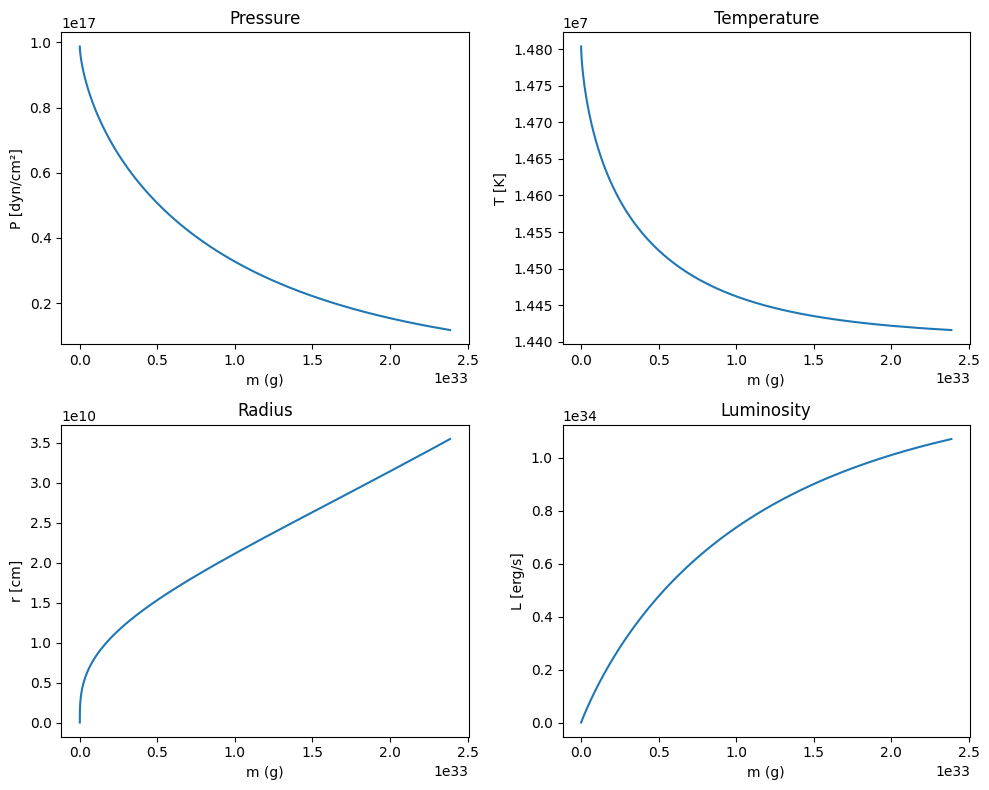

In [49]:
Pc, Tc, R_surface, L_surface = solution.x

# small mass to start
m0   = 1e-10 * M
m_fin= M

# initial m0
y0 = load1(Pc, Tc, M, mu, X, Z)

# integrate outward all the way to m=M
sol = solve_ivp(
    derivs,
    t_span=[m0, m_fin],
    y0=y0,
    args=(mu, X, Z, kappa_interp),
    method='BDF',        
    rtol=1e-6,
    atol=1e-8
)

m_full = sol.t
L_full, P_full, r_full, T_full = sol.y

fig, axes = plt.subplots(2,2,figsize=(10,8))
axes = axes.flatten()

axes[0].plot(m_full, P_full)
axes[0].set(xlabel='m (g)', ylabel='P [dyn/cm²]', title='Pressure')

axes[1].plot(m_full, T_full)
axes[1].set(xlabel='m (g)', ylabel='T [K]', title='Temperature')

axes[2].plot(m_full, r_full)
axes[2].set(xlabel='m (g)', ylabel='r [cm]', title='Radius')

axes[3].plot(m_full, L_full)
axes[3].set(xlabel='m (g)', ylabel='L [erg/s]', title='Luminosity')

plt.tight_layout()
plt.savefig('odeint.png', dpi=300)
plt.show()


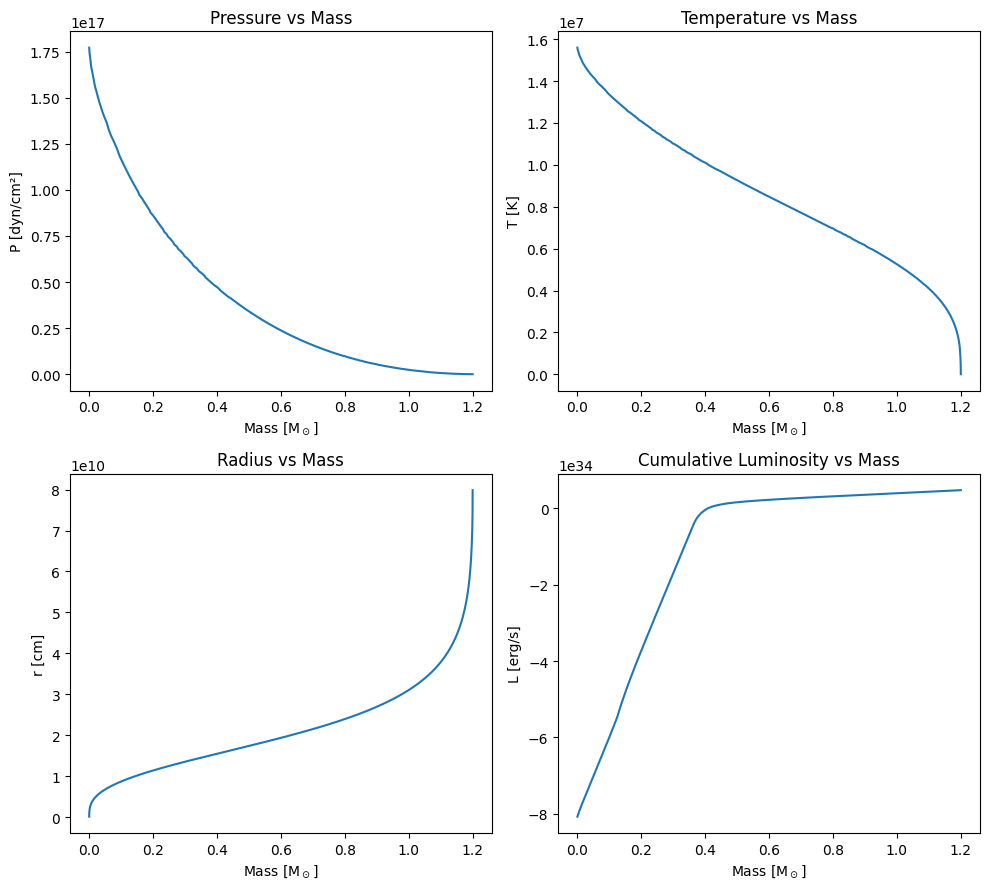

In [50]:
""" 
Read the documentation for the latest version of MESA and install MESA after
first installing its SDK. Modify the default stellar model located in mesa/star/work/
so that it corresponds to the same star for which you have calculated its ZAMS
structure. Use MESA to predict the ZAMS structure of that star for compari-
son with your own results. If you are unable to make MESA work on your own
computer, then you may compare your calculation with the MESA Isochrones &
Stellar Tracks (MIST) isochrone grid for partial credit.
"""

prof = MesaData('/Users/yuktaajay/Softwares/mesa-24.08.1/star/work/LOGS/profile10.data')
m     = prof.mass          
P     = 10**prof.logP             
T     = 10**prof.logT             
R     = (10**prof.logR) * 6.957e+10
pp    = prof.pp              
cno   = prof.cno                    

m_g = m * M_sun         
pp_clipped  = np.clip(pp,  -10, 2)
cno_clipped = np.clip(cno, -10, 2)
eps_tot     = 10**pp_clipped + 10**cno_clipped 
dm          = np.diff(m_g, prepend=0)
L_cum       = np.cumsum(eps_tot * dm) 


fig, axs = plt.subplots(2, 2, figsize=(10, 9))
axs = axs.flatten()

axs[0].plot(m, P)
axs[0].set(title='Pressure vs Mass', xlabel='Mass [M$_\odot$]', ylabel='P [dyn/cm²]')

axs[1].plot(m, T)
axs[1].set(title='Temperature vs Mass', xlabel='Mass [M$_\odot$]', ylabel='T [K]')

axs[2].plot(m, R)
axs[2].set(title='Radius vs Mass', xlabel='Mass [M$_\odot$]', ylabel='r [cm]')

axs[3].plot(m, L_cum)
axs[3].set(title='Cumulative Luminosity vs Mass', xlabel='Mass [M$_\odot$]', ylabel='L [erg/s]')

plt.tight_layout()
plt.savefig('mesaop.png', dpi=300)
plt.show()
